# Argo one filter scale

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy
import argopy
import scipy.ndimage as filter
import cartopy.crs as ccrs
import cartopy
import xrft
import scipy
import matplotlib

In [2]:
import filt_funcs as ff
import EV_funcs as ef

## Load boxes

#### Same boxes and naming conventions as the AGU_poster notebook

In [3]:
#North Pacific
np_ds=xr.open_dataset("202206/202206_lon:(-155,-145)_lat:(30,35).nc")
np = ff.get_ds_interp(np_ds,0,2000,4)

#North Atlantic
na_ds=xr.open_dataset("202206/202206_lon:(-55,-45)_lat:(40,45).nc")
na = ff.get_ds_interp(na_ds,0,2000,4)

#Southern Ocean
so_ds=xr.open_dataset("202206/202206_lon:(30,40)_lat:(-55,-50).nc")
so = ff.get_ds_interp(so_ds,0,2000,4)

#Indian Ocean
io_ds=xr.open_dataset("202206/202206_lon:(90,100)_lat:(-15,-10).nc")
io = ff.get_ds_interp(io_ds,0,2000,4)

In [4]:
np_param=[-155,-145,30,35]
na_param=[-55,-45,40,45]
so_param=[30,40,-55,-50]
io_param=[90,100,-15,-10]

In [5]:
np_lon,np_lat=numpy.average((np_param[0],np_param[1])),numpy.average((np_param[2],np_param[3]))
na_lon,na_lat=numpy.average((na_param[0],na_param[1])),numpy.average((na_param[2],na_param[3]))
so_lon,so_lat=numpy.average((so_param[0],so_param[1])),numpy.average((so_param[2],so_param[3]))
io_lon,io_lat=numpy.average((io_param[0],io_param[1])),numpy.average((io_param[2],io_param[3]))

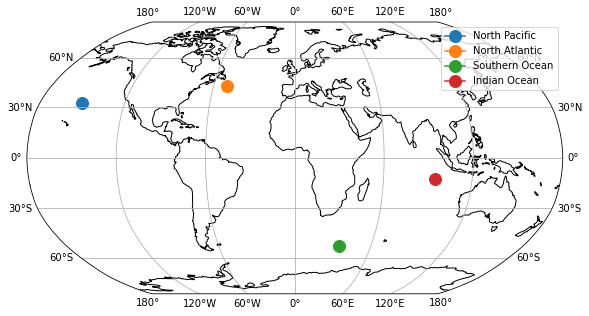

In [6]:
plt.figure(figsize=(10,5))
ax=plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.plot(np_lon,np_lat,transform=ccrs.PlateCarree(),label='North Pacific',marker='o',markersize=12)
plt.plot(na_lon,na_lat,transform=ccrs.PlateCarree(),label='North Atlantic',marker='o',markersize=12)
plt.plot(so_lon,so_lat,transform=ccrs.PlateCarree(),label='Southern Ocean',marker='o',markersize=12)
plt.plot(io_lon,io_lat,transform=ccrs.PlateCarree(),label='Indian Ocean',marker='o',markersize=12)
plt.legend()

#### New boxes around the Soutern Ocean

In [10]:
so1_ds = xr.open_dataset("202206/202206_lon:(120,130)_lat:(-60,-55).nc")
so1 = ff.get_ds_interp(so1_ds,0,2000,4)

so2_ds = xr.open_dataset("202206/202206_lon:(-180,-170)_lat:(-60,-55).nc")
so2 = ff.get_ds_interp(so2_ds,0,2000,4)

so3_ds = xr.open_dataset("202206/202206_lon:(-120,-110)_lat:(-60,-55).nc")
so3 = ff.get_ds_interp(so3_ds,0,2000,4)

so4_ds = xr.open_dataset("202206/202206_lon:(-60,-50)_lat:(-60,-55).nc")
so4 = ff.get_ds_interp(so4_ds,0,2000,4)

so5_ds = xr.open_dataset("202206/202206_lon:(0,10)_lat:(-60,-55).nc")
so5 = ff.get_ds_interp(so5_ds,0,2000,4)

so6_ds = xr.open_dataset("202206/202206_lon:(60,70)_lat:(-60,-55).nc")
so6 = ff.get_ds_interp(so6_ds,0,2000,4)

In [11]:
so1_param = [120,130,-60,-55]
so2_param = [-180,-170,-60,-55]
so3_param = [-120,-110,-60,-55]
so4_param = [-60,-50,-60,-55]
so5_param = [0,10,-60,-55]
so6_param = [60,70,-60,-55]

In [12]:
so1_lon,so1_lat=numpy.average((so1_param[0],so1_param[1])),numpy.average((so1_param[2],so1_param[3]))
so2_lon,so2_lat=numpy.average((so2_param[0],so2_param[1])),numpy.average((so2_param[2],so2_param[3]))
so3_lon,so3_lat=numpy.average((so3_param[0],so3_param[1])),numpy.average((so3_param[2],so3_param[3]))
so4_lon,so4_lat=numpy.average((so4_param[0],so4_param[1])),numpy.average((so4_param[2],so4_param[3]))
so5_lon,so5_lat=numpy.average((so5_param[0],so5_param[1])),numpy.average((so5_param[2],so5_param[3]))
so6_lon,so6_lat=numpy.average((so6_param[0],so6_param[1])),numpy.average((so6_param[2],so6_param[3]))

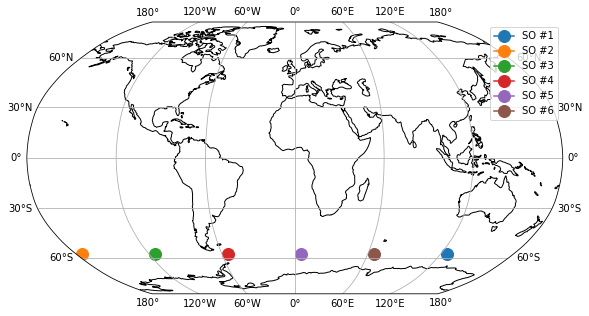

In [13]:
plt.figure(figsize=(10,5))
ax=plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.plot(so1_lon,so1_lat,transform=ccrs.PlateCarree(),label='SO #1',marker='o',markersize=12)
plt.plot(so2_lon,so2_lat,transform=ccrs.PlateCarree(),label='SO #2',marker='o',markersize=12)
plt.plot(so3_lon,so3_lat,transform=ccrs.PlateCarree(),label='SO #3',marker='o',markersize=12)
plt.plot(so4_lon,so4_lat,transform=ccrs.PlateCarree(),label='SO #4',marker='o',markersize=12)
plt.plot(so5_lon,so5_lat,transform=ccrs.PlateCarree(),label='SO #5',marker='o',markersize=12)
plt.plot(so6_lon,so6_lat,transform=ccrs.PlateCarree(),label='SO #6',marker='o',markersize=12)
plt.legend()

## MKE/EKE method from Steinberg paper

These eqations are for energy at one spatial scale, where the eddy kinetic energy at scales smaller than the filter scale (EKE) and mean kinetic energy at scales larger than the filter scale (MKE) are:

$$
MKE = <u>^2
$$
$$
EKE = <u^2> - <u>^2
$$

(based on this paper: [Steinberg](https://journals.ametsoc.org/view/journals/phoc/52/8/JPO-D-21-0269.1.xml))

The methods/functions seem to be working well, but the process of making the calculations repeatedly for multiple locations is a bit complex. I think we need a new set of functions to take an array with temperature and salinity profiles, and return an array with EKE values. Obviously need the ability to switch between temperature and salinity (density, spice, etc) variables. Potential tasks for separate functions:
- Filtering the profiles: use ff.get_filt.single()
- Computing filtered profile, squared (MKE)
- Computing squared profile, filtered
- Computing EKE (difference between the above two values)

Should make a new file EKE_funcs.py with these functions

## Temperature

#### Same boxes and naming conventions as the AGU_poster notebook

In [7]:
np_CT_EV = ef.get_eddy_variance(np, 100)
na_CT_EV = ef.get_eddy_variance(na, 100)
so_CT_EV = ef.get_eddy_variance(so, 100)
io_CT_EV = ef.get_eddy_variance(io, 100)

In [8]:
np_SA_EV = ef.get_eddy_variance(np, 100, variable='SA')
na_SA_EV = ef.get_eddy_variance(na, 100, variable='SA')
so_SA_EV = ef.get_eddy_variance(so, 100, variable='SA')
io_SA_EV = ef.get_eddy_variance(io, 100, variable='SA')

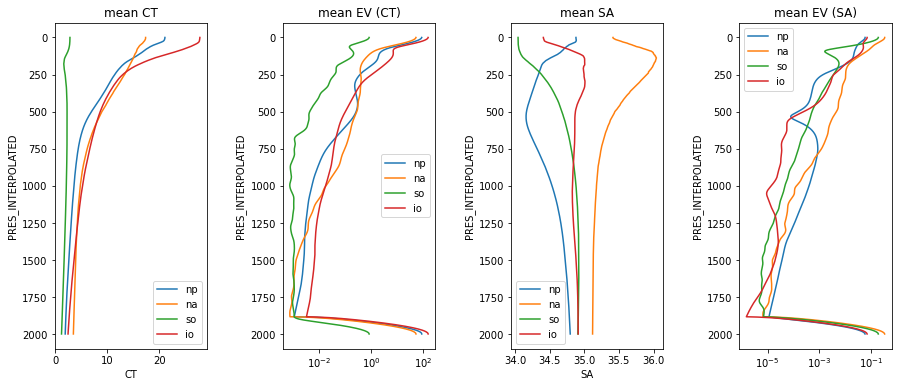

In [9]:
plt.figure(figsize=(15,6))

plt.subplot(1,4,1)
np.CT.mean('N_PROF').plot(y='PRES_INTERPOLATED', label ='np')
na.CT.mean('N_PROF').plot(y='PRES_INTERPOLATED', label ='na')
so.CT.mean('N_PROF').plot(y='PRES_INTERPOLATED', label ='so')
io.CT.mean('N_PROF').plot(y='PRES_INTERPOLATED', label ='io')
plt.gca().invert_yaxis()
plt.title('mean CT')
plt.legend()

plt.subplot(1,4,2)
np_CT_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='np')
na_CT_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='na')
so_CT_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so')
io_CT_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='io')
plt.gca().invert_yaxis()
plt.title('mean EV (CT)')
plt.xscale('log')
plt.legend()

plt.subplot(1,4,3)
np.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label ='np')
na.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label ='na')
so.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label ='so')
io.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label ='io')
plt.gca().invert_yaxis()
plt.title('mean SA')
plt.legend()

plt.subplot(1,4,4)
np_SA_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='np')
na_SA_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='na')
so_SA_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so')
io_SA_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='io')
plt.gca().invert_yaxis()
plt.title('mean EV (SA)')
plt.xscale('log')
plt.legend()

plt.subplots_adjust(wspace=0.5)

#### New boxes around the Southern Ocean

In [14]:
so1_CT_EV = ef.get_eddy_variance(so1, 100)
so2_CT_EV = ef.get_eddy_variance(so2, 100)
so3_CT_EV = ef.get_eddy_variance(so3, 100)
so4_CT_EV = ef.get_eddy_variance(so4, 100)
so5_CT_EV = ef.get_eddy_variance(so5, 100)
so6_CT_EV = ef.get_eddy_variance(so6, 100)

In [15]:
so1_SA_EV = ef.get_eddy_variance(so1, 100, variable='SA')
so2_SA_EV = ef.get_eddy_variance(so2, 100, variable='SA')
so3_SA_EV = ef.get_eddy_variance(so3, 100, variable='SA')
so4_SA_EV = ef.get_eddy_variance(so4, 100, variable='SA')
so5_SA_EV = ef.get_eddy_variance(so5, 100, variable='SA')
so6_SA_EV = ef.get_eddy_variance(so6, 100, variable='SA')

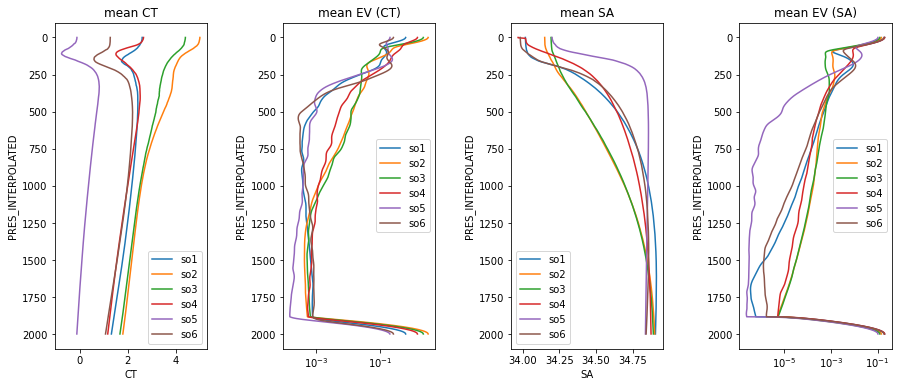

In [17]:
plt.figure(figsize=(15,6))

plt.subplot(1,4,1)
so1.CT.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so1')
so2.CT.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so2')
so3.CT.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so3')
so4.CT.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so4')
so5.CT.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so5')
so6.CT.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so6')
plt.gca().invert_yaxis()
plt.title('mean CT')
plt.legend()

plt.subplot(1,4,2)
so1_CT_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so1')
so2_CT_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so2')
so3_CT_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so3')
so4_CT_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so4')
so5_CT_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so5')
so6_CT_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so6')
plt.gca().invert_yaxis()
plt.title('mean EV (CT)')
plt.xscale('log')
plt.legend()

plt.subplot(1,4,3)
so1.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so1')
so2.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so2')
so3.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so3')
so4.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so4')
so5.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so5')
so6.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so6')
plt.gca().invert_yaxis()
plt.title('mean SA')
plt.legend()

plt.subplot(1,4,4)
so1_SA_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so1')
so2_SA_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so2')
so3_SA_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so3')
so4_SA_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so4')
so5_SA_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so5')
so6_SA_EV.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so6')
plt.gca().invert_yaxis()
plt.title('mean EV (SA)')
plt.xscale('log')
plt.legend()

plt.subplots_adjust(wspace=0.5)

### Salinity EKE Investigation

Text(0.5, 0, 'so region #')

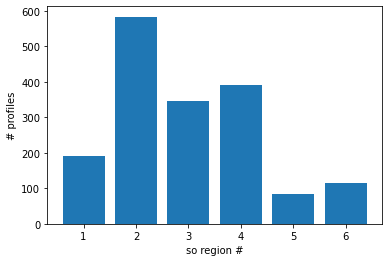

In [18]:
plt.bar(range(1,7),[len(so1.N_PROF),len(so2.N_PROF),len(so3.N_PROF),len(so4.N_PROF),len(so5.N_PROF),len(so6.N_PROF)])
plt.ylabel('# profiles')
plt.xlabel('so region #')

Interesting here that that lowest number of profiles (so5, s06, so1) correspond to the most horizontal lines and the most number of profiles (so2, so4, so3) correspond to the fewest horizontal lines. Maybe this is related to the smoothness issue? I'm going to create EKE plots with a higher filter scale first to see if that fixes the issue.

In [20]:
so1_SA_EV_200 = ef.get_eddy_variance(so1, 200, variable='SA')
so2_SA_EV_200 = ef.get_eddy_variance(so2, 200, variable='SA')
so3_SA_EV_200 = ef.get_eddy_variance(so3, 200, variable='SA')
so4_SA_EV_200 = ef.get_eddy_variance(so4, 200, variable='SA')
so5_SA_EV_200 = ef.get_eddy_variance(so5, 200, variable='SA')
so6_SA_EV_200 = ef.get_eddy_variance(so6, 200, variable='SA')

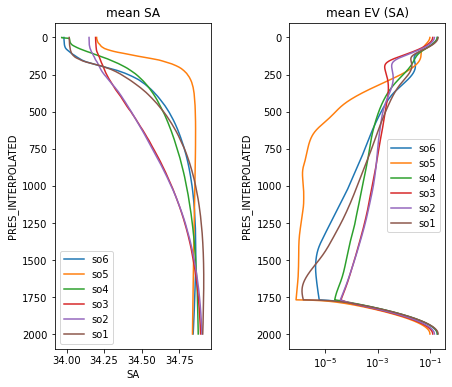

In [21]:
plt.figure(figsize=(7,6))

plt.subplot(1,2,1)
so6.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so6')
so5.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so5')
so4.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so4')
so3.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so3')
so2.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so2')
so1.SA.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so1')
plt.gca().invert_yaxis()
plt.title('mean SA')
plt.legend()

plt.subplot(1,2,2)
so6_SA_EV_200.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so6')
so5_SA_EV_200.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so5')
so4_SA_EV_200.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so4')
so3_SA_EV_200.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so3')
so2_SA_EV_200.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so2')
so1_SA_EV_200.mean('N_PROF').plot(y='PRES_INTERPOLATED', label='so1')
plt.gca().invert_yaxis()
plt.title('mean EV (SA)')
plt.xscale('log')
plt.legend()

plt.subplots_adjust(wspace=0.5)

Interesting. This seems to have greatly minimized the problem for regions that had many profiles, but not changed much for regions that had fewer. Next let's try looking at the salinity profiles themselves to see if there's anything visually strange.

Text(0.5, 1.0, 'so6')

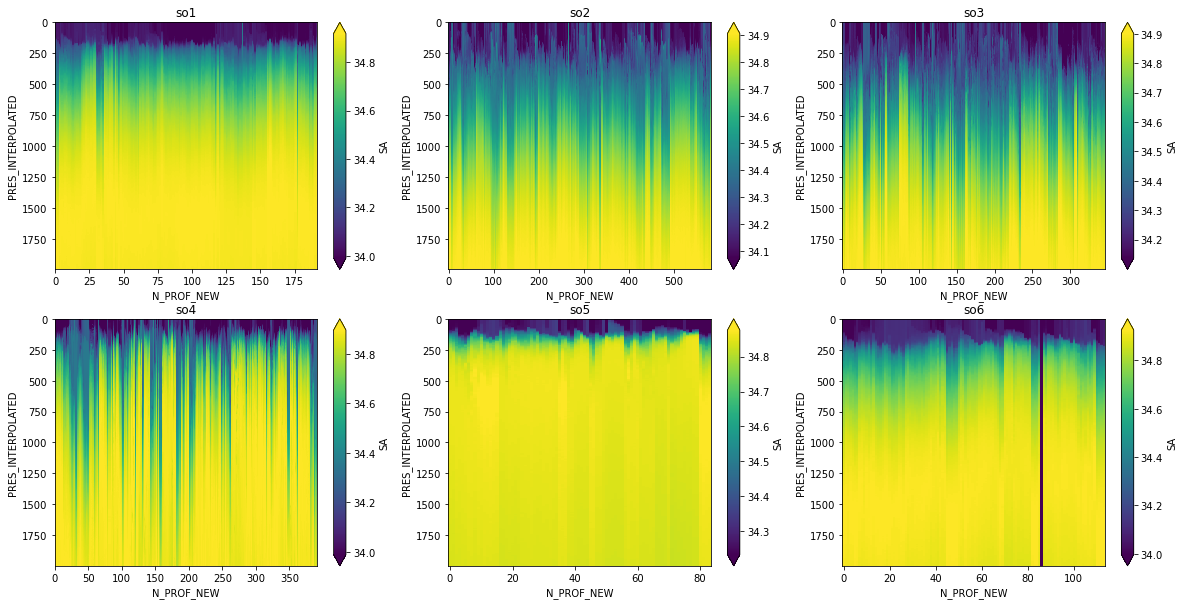

In [22]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
so1.SA.plot(x='N_PROF_NEW', y='PRES_INTERPOLATED', robust=True)
plt.gca().invert_yaxis()
plt.title('so1')

plt.subplot(2,3,2)
so2.SA.plot(x='N_PROF_NEW', y='PRES_INTERPOLATED', robust=True)
plt.gca().invert_yaxis()
plt.title('so2')

plt.subplot(2,3,3)
so3.SA.plot(x='N_PROF_NEW', y='PRES_INTERPOLATED', robust=True)
plt.gca().invert_yaxis()
plt.title('so3')

plt.subplot(2,3,4)
so4.SA.plot(x='N_PROF_NEW', y='PRES_INTERPOLATED', robust=True)
plt.gca().invert_yaxis()
plt.title('so4')

plt.subplot(2,3,5)
so5.SA.plot(x='N_PROF_NEW', y='PRES_INTERPOLATED', robust=True)
plt.gca().invert_yaxis()
plt.title('so5')

plt.subplot(2,3,6)
so6.SA.plot(x='N_PROF_NEW', y='PRES_INTERPOLATED', robust=True)
plt.gca().invert_yaxis()
plt.title('so6')

Right, this is starting to make more sense. The three regions with more profiles (so2, so4, so3) have more variability between profiles which could help explain why their EKE values have greater magnitude and less noise. The three regions with fewer profiles (so5, so6, so1) also seem more uniform, so it would make sense that the EKE values would be lower and have more noise, even at larger filter scales. Next, I'd like to examine why there seems to be a region of anomalous salinity in so6 --> is this equipment error?

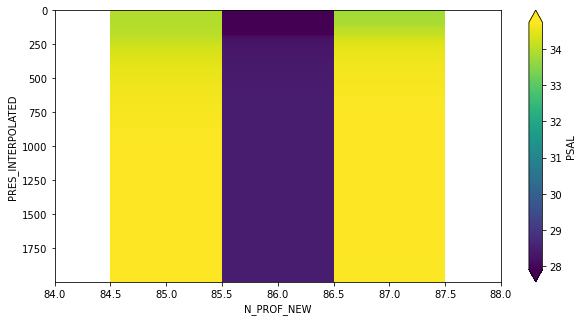

In [36]:
plt.figure(figsize=(10,5))
so6.SA.where(so6.N_PROF_NEW>84).where(so6.N_PROF_NEW<88).plot(x='N_PROF_NEW', y='PRES_INTERPOLATED', robust=True)
plt.xlim(84,88)
plt.gca().invert_yaxis()

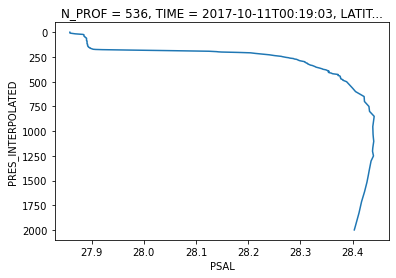

In [37]:
so6.SA.isel(N_PROF=86).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

So this doesn't necessarily look like equipment error because there is still a profile with fresher water at the surface and more saline water at depth? But still odd to have significantly lower values than every other profile in that box.